## **Gaussian Process Emulator with Functional Data**

In many scenarios, we may be dealing with _functional_ data. This means that the input, output, or both, are sampled over a particular dimension (e.g. time). In `twinlab`, data are presented in column-feature format, meaning a single data sample of functional format may contain hundreds or thousands of columns.

Gaussian Process models do not scale well to these scenarios, so we provide the ability to perform dimensionality reduction before model fitting.

This notebook will cover:

- How to decompose functional inputs and outputs


In [ ]:
# Third party imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from itertools import product

# twinLab import
import twinlab as tl

### **Problem Formulation**

Here, we define a problem with two input dimensions and one functional output defined over a grid of sample locations


In [2]:
# Grid over which the functional output is defined
grid = np.linspace(0, 1)


# True function: Forrester function with variable a and b
def model(x):
    return (x[0] * grid - 2) ** 2 * np.sin(x[1] * grid - 4)


# Define input data
x = np.random.uniform(size=(100, 2))
x[:, 0] = x[:, 0] * 4 + 4
x[:, 1] = x[:, 1] * 4 + 10

# Compute output data
y = np.zeros((x.shape[0], grid.size))

for i, x_i in enumerate(x):
    y[i, :] = model(x_i)

y = {"y_{}".format(i): y[:, i] for i in range(grid.size)}

# Save to DataFrame
df = pd.DataFrame({"x1": x[:, 0], "x2": x[:, 1], **y})
df.head()

,x1,x2,y_0,y_1,y_2,y_3,y_4,y_5,y_6,y_7,...,y_40,y_41,y_42,y_43,y_44,y_45,y_46,y_47,y_48,y_49
0,7.414301,11.018019,3.02721,2.023279,1.144970,0.436951,-0.079781,-0.406262,-0.562111,-0.580705,...,-15.774398,-15.450889,-14.113138,-11.705380,-8.237046,-3.789443,1.481852,7.349417,13.521483,19.654427
1,6.304205,11.984661,3.02721,2.017095,1.096050,0.323891,-0.263976,-0.656197,-0.862844,-0.910992,...,-4.744064,-2.707516,-0.123011,2.892605,6.171684,9.503159,12.644287,15.336175,17.322214,18.368218
2,5.137349,12.259663,3.02721,2.052248,1.123153,0.305690,-0.354522,-0.833215,-1.126590,-1.248634,...,-1.308210,-0.132601,1.289331,2.878993,4.530698,6.117403,7.499011,8.532784,9.085149,9.044039
3,7.531477,10.680896,3.02721,2.036901,1.174593,0.480866,-0.025907,-0.347924,-0.504691,-0.528550,...,-17.206712,-18.040728,-17.938481,-16.775204,-14.478395,-11.038291,-6.515277,-1.043478,5.170011,11.850562
4,5.214434,13.847381,3.02721,1.952435,0.923135,0.029968,-0.665854,-1.134694,-1.376846,-1.417719,...,4.341581,5.385779,6.097801,6.343361,6.016765,5.056440,3.457606,1.280389,-1.347984,-4.237762


In [3]:
# Define the name of the dataset
dataset_id = "FunctionalGP_Data"

# Intialise a Dataset object
dataset = tl.Dataset(id=dataset_id)

# Upload the dataset
dataset.upload(df, verbose=True)

Dataframe is uploading.
Processing dataset
Dataset FunctionalGP_Data was processed.


### **Functional Emulator Workflow**

In `twinlab`, dimensionality reduction is implemented in the form of truncated Singular Value Decomposition (tSVD), and is accessible via the parameters `decompose_inputs` and `decompose_outputs` as part of the `TrainParams` object, and the ratio of retained singular components are controlled by the parameters `input_explained_variance` and `output_explained_variance`.

One can decompose the inputs, outputs, or both in the same `Emulator`.


In [4]:
# Initialise emulator
emulator_id = "FunctionalGP"

emulator = tl.Emulator(id=emulator_id)

# Define the training parameters for your emulator
output_columns = df.columns[2:].to_list()
params = tl.TrainParams(
    train_test_ratio=0.75,
    estimator="gaussian_process_regression",
    decompose_input=False,
    decompose_output=True,
    output_explained_variance=0.99999,
)

# Train the emulator using the train method
emulator.train(
    dataset=dataset,
    inputs=["x1", "x2"],
    outputs=output_columns,
    params=params,
    verbose=True,
)

Model FunctionalGP has begun training.
Training complete!



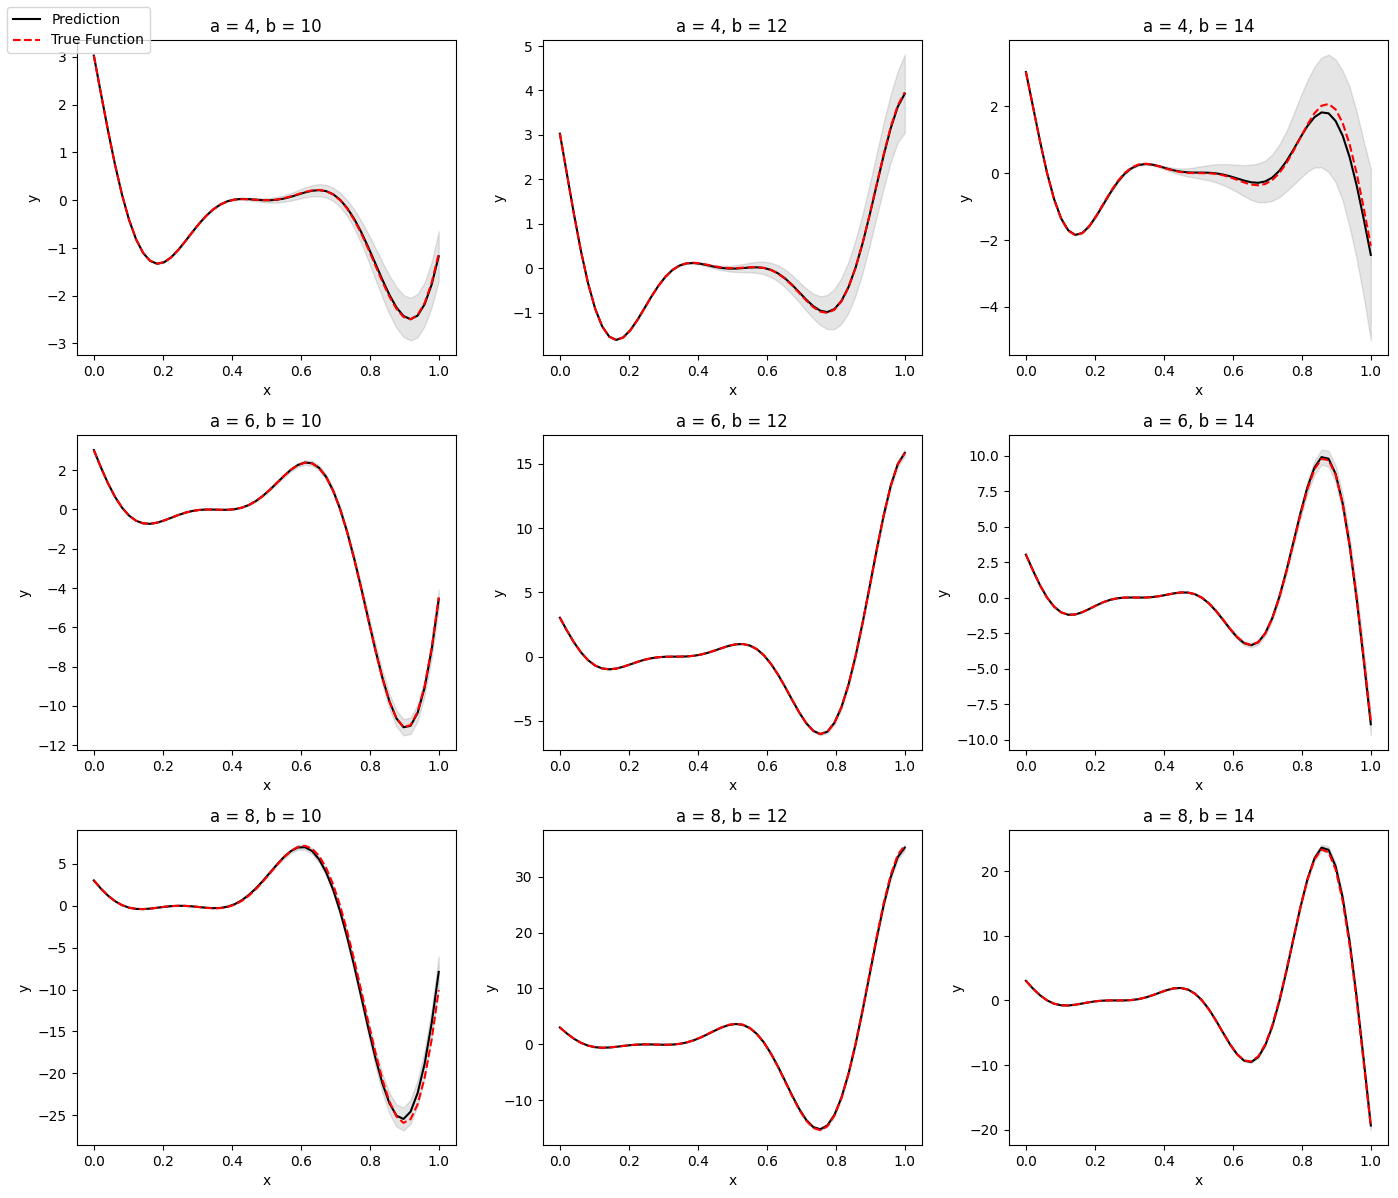

In [5]:
# Create grid of output plots
grid = np.linspace(0, 1)

x1 = [4, 6, 8]
x2 = [10, 12, 14]

X = np.array(list(product(x1, x2)))
ax_i = list(product([0, 1, 2], [0, 1, 2]))

# Create output plot and save in directory
fig, axes = plt.subplots(figsize=(14, 12), nrows=3, ncols=3)

# Setup legend
legend_labels = {}

for i, x_i in enumerate(X):
    r, c = ax_i[i]
    ax = axes[r, c]

    X_test = pd.DataFrame(x_i[np.newaxis, :], columns=["x1", "x2"])
    y_test = model(X_test.values.flatten())

    y_pred = emulator.predict(X_test)
    y_df = pd.concat([y_pred[0], y_pred[1]], axis=0)
    y_mean, y_stdev = y_df.iloc[0, :], y_df.iloc[1, :]
    y_mean = y_mean.values
    y_stdev = y_stdev.values

    ax.set_title("a = {}, b = {}".format(x_i[0], x_i[1]))
    ax.plot(grid, y_mean.flatten(), c="k")
    ax.plot(grid, y_test.flatten(), c="red", linestyle="dashed")
    ax.fill_between(
        grid,
        (y_mean - 1.96 * y_stdev).flatten(),
        (y_mean + 1.96 * y_stdev).flatten(),
        color="k",
        alpha=0.1,
    )

    ax.set_xlabel("x")
    ax.set_ylabel("y")

# Store labels for the legend
legend_labels[f"Prediction"] = plt.Line2D([0], [0], color="k")
legend_labels[f"True Function"] = plt.Line2D([0], [0], color="red", linestyle="dashed")

# Print legend
fig.legend(legend_labels.values(), legend_labels.keys(), loc="upper left")
fig.tight_layout()

In [6]:
# Delete emulator and dataset
emulator.delete()

dataset.delete()